In [ ]:
!gdown --id 1tf3y7AsGztdlYR07QJM_2bQXm9OTqkCg

In [ ]:
!gdown --id 1L8vitrcQw7iu8XmBEofkVnKVHOR5K6Q7

In [ ]:
!unzip -o sunday-meditator.zip

In [ ]:
!unzip -o sunday-non-meditator.zip

In [ ]:
!pip install -U mne

In [18]:
import mne
import numpy as np
import os
from scipy.signal import hilbert
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [31]:
meditator_data_path = '/content/sunday-meditator'
non_meditator_data_path = '/content/sunday-non-meditator'
sfreq = 512  # Sampling frequency


# Load and Process EEG Data

In [32]:
def load_and_trim(data_path, target_length=3600):
    all_envelopes = []
    for file_name in sorted(os.listdir(data_path)):
        if not file_name.endswith('.fif'):
            continue
        file_path = os.path.join(data_path, file_name)
        raw = mne.io.read_raw_fif(file_path, preload=True, verbose=False)
        raw.crop(tmax=target_length - 1/raw.info['sfreq'])  # Adjusting to ensure consistency
        all_envelopes.append(raw)
    return all_envelopes

meditator_raws = load_and_trim(meditator_data_path)
non_meditator_raws = load_and_trim(non_meditator_data_path)

<ipython-input-32-dc2b6d18a98c>:7: RuntimeWarning: This filename (/content/sunday-meditator/med_01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True, verbose=False)
<ipython-input-32-dc2b6d18a98c>:7: RuntimeWarning: This filename (/content/sunday-meditator/med_02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True, verbose=False)
<ipython-input-32-dc2b6d18a98c>:7: RuntimeWarning: This filename (/content/sunday-meditator/med_03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, ra

In [33]:
print(f"Meditator samples: {len(meditator_raws[0])}, Non-Meditator samples: {len(non_meditator_raws[0])}")


Meditator samples: 900000, Non-Meditator samples: 900000


# Hilbert transform and trim

In [34]:
from scipy.signal import hilbert

def apply_hilbert_and_trim(raws):
    min_length = np.inf
    envelopes = []
    for raw in raws:
        data, _ = raw[:]
        envelope = np.abs(hilbert(data))
        min_length = min(min_length, envelope.shape[1])
        envelopes.append(envelope)
    # Trim based on the shortest recording
    trimmed_envelopes = [env[:, :min_length] for env in envelopes]
    return trimmed_envelopes, min_length

meditator_envelopes, med_min_length = apply_hilbert_and_trim(meditator_raws)
non_meditator_envelopes, non_med_min_length = apply_hilbert_and_trim(non_meditator_raws)


In [35]:
print(f"Shortest Meditator length: {med_min_length}, Shortest Non-Meditator length: {non_med_min_length}")


Shortest Meditator length: 900000, Shortest Non-Meditator length: 900000


# Calculate Average Amplitude Envelope

In [36]:
def calculate_average_amplitude(envelopes):
    avg_amplitude = np.mean([np.mean(env, axis=0) for env in envelopes], axis=0)
    return avg_amplitude

avg_amp_meditator = calculate_average_amplitude(meditator_envelopes)
avg_amp_non_meditator = calculate_average_amplitude(non_meditator_envelopes)


# Create the Times Array and Plot

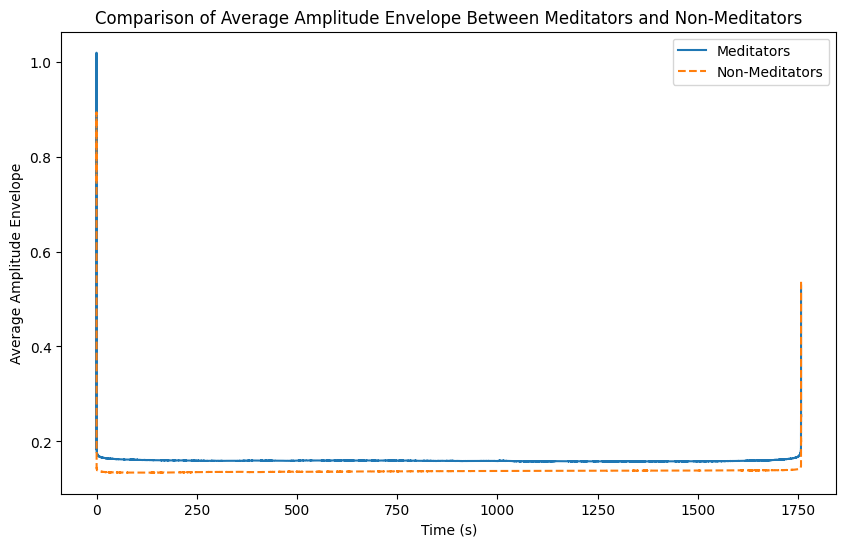

In [37]:
# Use the shorter of the two lengths to ensure compatibility
min_length = min(med_min_length, non_med_min_length)
times = np.arange(min_length) / sfreq

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(times[:len(avg_amp_meditator)], avg_amp_meditator, label='Meditators')  # Ensure times is correctly indexed
plt.plot(times[:len(avg_amp_non_meditator)], avg_amp_non_meditator, label='Non-Meditators', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Average Amplitude Envelope')
plt.legend()
plt.title('Comparison of Average Amplitude Envelope Between Meditators and Non-Meditators')
plt.show()


In [38]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(avg_amp_meditator, avg_amp_non_meditator)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3g}")
if p_val < 0.05:
    print("The difference in average amplitude envelope between meditators and non-meditators is statistically significant.")
else:
    print("No significant difference in average amplitude envelope between meditators and non-meditators was found.")


T-statistic: 5091.634, P-value: 0
The difference in average amplitude envelope between meditators and non-meditators is statistically significant.


In [39]:
# Exclude first and last 10 seconds (sfreq = 512 Hz)
start_artifact = 10 * sfreq
end_artifact = -10 * sfreq

# Perform t-test without artifacts
t_stat, p_val = ttest_ind(avg_amp_meditator[start_artifact:end_artifact],
                          avg_amp_non_meditator[start_artifact:end_artifact])

print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3g}")
if p_val < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")


T-statistic: 10227.622, P-value: 0
The difference is statistically significant.
